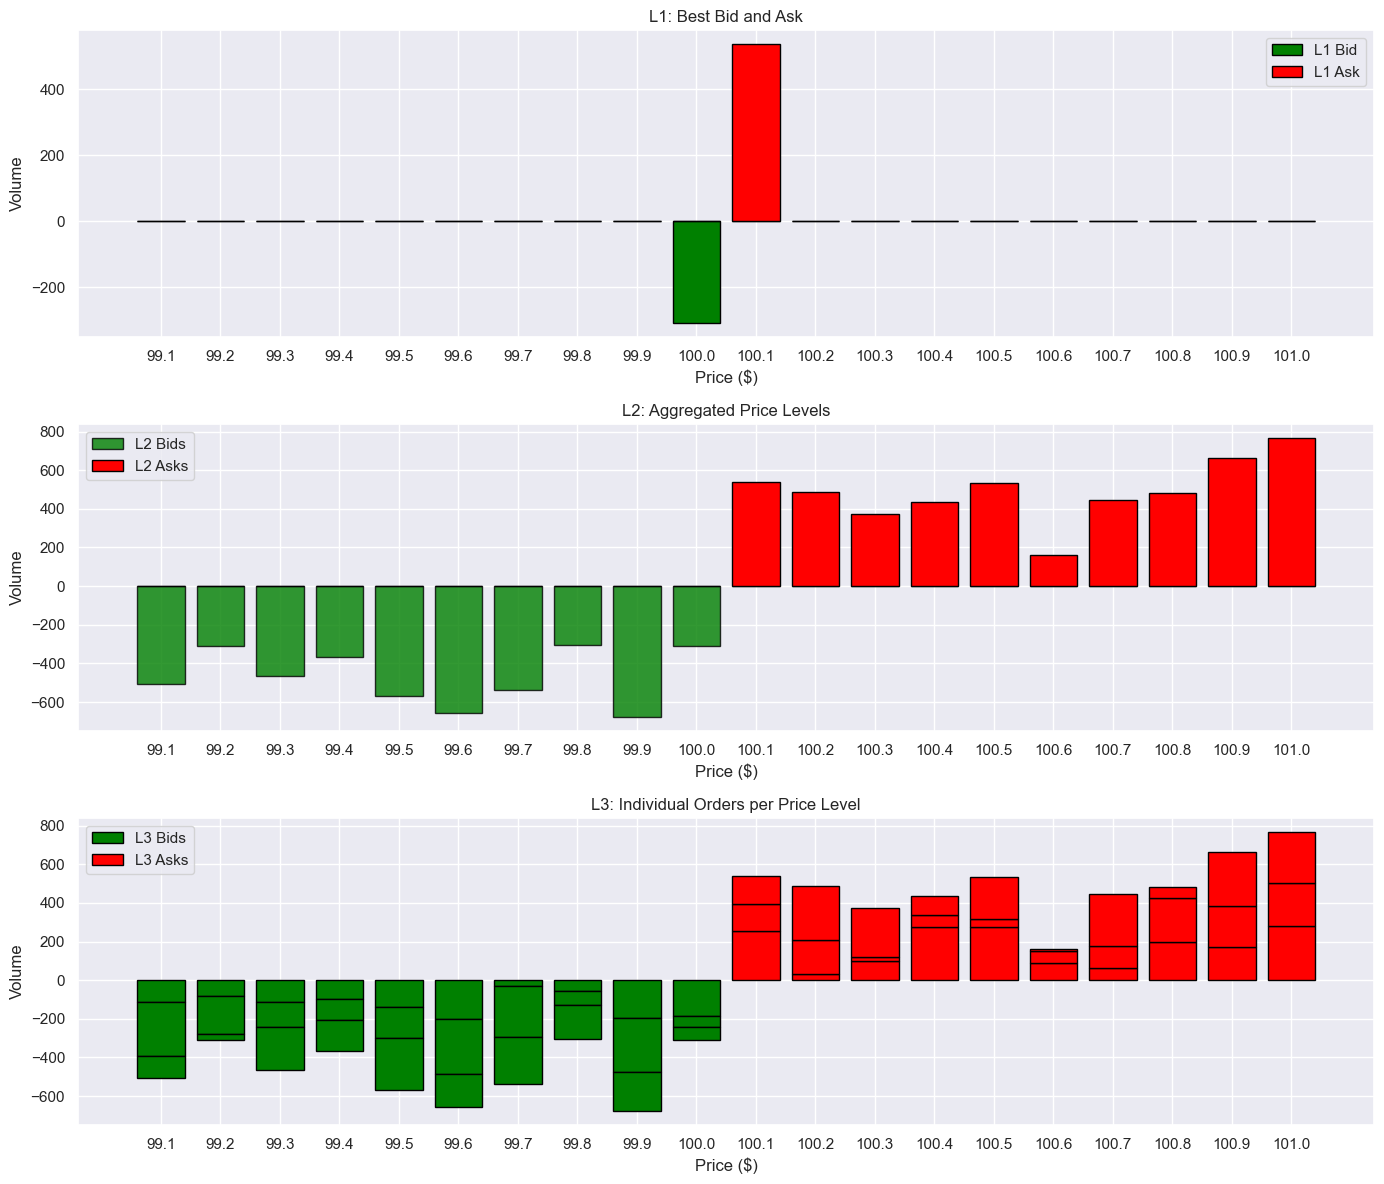

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# --- Generate Full L3 DataFrame Only ---
def generate_l3_data(price_levels):
    # Ensure 10 bids and 10 asks
    mid_price = 100
    bids = price_levels[price_levels <= mid_price][:10]
    asks = price_levels[price_levels > mid_price][:10]
    prices = np.concatenate([bids, asks])
    sides = ['bid'] * len(bids) + ['ask'] * len(asks)

    np.random.seed(42)  # For reproducibility

    order_id = 1
    rows = []
    for price, side in zip(prices, sides):
        for j in range(3):
            size = np.random.randint(10, 300)
            timestamp = pd.Timestamp('2025-01-01') + pd.Timedelta(seconds=order_id + j)
            rows.append({
                'order_id': order_id,
                'price': float(price),
                'size': size,
                'side': side,
                'timestamp': timestamp
            })
            order_id += 1

    return pd.DataFrame(rows)

# --- Derive L1 from L3 ---
def extract_l1(l3_df):
    best_bid = l3_df[l3_df['side'] == 'bid'].sort_values(by='price', ascending=False).iloc[0]
    best_ask = l3_df[l3_df['side'] == 'ask'].sort_values(by='price', ascending=True).iloc[0]
    return {
        'best_bid_price': best_bid['price'],
        'best_bid_size': l3_df[(l3_df['price'] == best_bid['price']) & (l3_df['side'] == 'bid')]['size'].sum(),
        'best_ask_price': best_ask['price'],
        'best_ask_size': l3_df[(l3_df['price'] == best_ask['price']) & (l3_df['side'] == 'ask')]['size'].sum()
    }

# --- Derive L2 from L3 ---
def aggregate_l2_from_l3(l3_df):
    return l3_df.groupby(['price', 'side'])['size'].sum().reset_index()

# --- Main ---
if __name__ == '__main__':
    price_levels = np.arange(99.1, 101, 0.1)  # example: from 98.5 to 101.5

    l3_df = generate_l3_data(price_levels)
    l1 = extract_l1(l3_df)
    l2 = aggregate_l2_from_l3(l3_df)
    # Only use the 10 bids and 10 asks for plotting
    bids = price_levels[price_levels <= 100][:10]
    asks = price_levels[price_levels > 100][:10]
    plot_levels = np.concatenate([bids, asks])

    fig, axs = plt.subplots(3, 1, figsize=(14, 12))
    sns.set()

    # --- L1 ---
    bid_sizes_l1 = [l1['best_bid_size'] * -1 if price == l1['best_bid_price'] else 0 for price in plot_levels]
    ask_sizes_l1 = [l1['best_ask_size'] if price == l1['best_ask_price'] else 0 for price in plot_levels]
    axs[0].bar(plot_levels, bid_sizes_l1, width=0.08, color='green', alpha=1, label='L1 Bid', edgecolor='black')
    axs[0].bar(plot_levels, ask_sizes_l1, width=0.08, color='red', alpha=1, label='L1 Ask', edgecolor='black')
    axs[0].set_xticks(plot_levels)
    axs[0].set_title("L1: Best Bid and Ask")
    axs[0].set_ylabel("Volume")
    axs[0].set_xlabel("Price ($)")
    axs[0].legend()

    # --- L2 ---
    bids_l2 = l2[l2['side'] == 'bid'].set_index('price').reindex(plot_levels, fill_value=0)
    asks_l2 = l2[l2['side'] == 'ask'].set_index('price').reindex(plot_levels, fill_value=0)
    axs[1].bar(plot_levels, bids_l2['size'] * -1, width=0.08, color='green', alpha=0.8, label='L2 Bids', edgecolor='black')
    axs[1].bar(plot_levels, asks_l2['size'], width=0.08, color='red', alpha=1, label='L2 Asks', edgecolor='black')
    axs[1].set_title("L2: Aggregated Price Levels")
    axs[1].set_ylabel("Volume")
    axs[1].legend()
    axs[1].set_xlabel("Price ($)")
    axs[1].set_xticks(plot_levels)

    # --- L3 ---
    grouped = l3_df.groupby(['price', 'side'])
    bar_width = 0.08
    colors = {'bid': 'green', 'ask': 'red'}
    for (price, side), group in grouped:
        if price not in plot_levels:
            continue
        total_height = 0
        for _, row in group.iterrows():
            axs[2].bar(
                price,
                row['size'] * (-1 if side == 'bid' else 1),
                bottom=total_height if side == 'ask' else -total_height,
                width=bar_width,
                color=colors[side],
                edgecolor='black',
                linewidth=1,
                alpha=1,
                zorder=1
            )
            total_height += row['size']
    axs[2].set_title("L3: Individual Orders per Price Level")
    axs[2].set_xlabel("Price ($)")
    axs[2].set_ylabel("Volume")
    axs[2].set_xticks(plot_levels)
    custom_legend = [
        Patch(facecolor='green', edgecolor='black', label='L3 Bids'),
        Patch(facecolor='red', edgecolor='black', label='L3 Asks')
    ]
    axs[2].legend(handles=custom_legend)
    plt.tight_layout()
    plt.show()

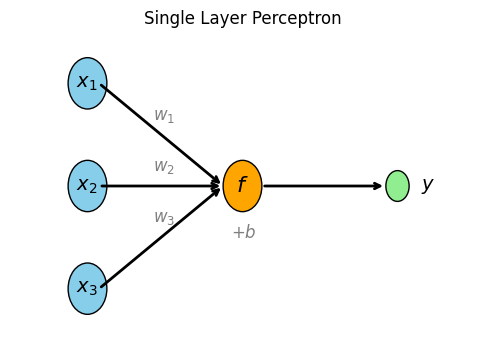

In [9]:
import matplotlib.pyplot as plt

def draw_perceptron():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')

    # Draw input nodes
    input_coords = [(1, 2.5), (1, 1.5), (1, 0.5)]
    for i, (x, y) in enumerate(input_coords):
        circle = plt.Circle((x, y), 0.25, color='skyblue', ec='black', zorder=2)
        ax.add_patch(circle)
        ax.text(x-0.15, y, f'$x_{i+1}$', fontsize=14, va='center')

    # Draw perceptron node
    perceptron_x, perceptron_y = 3, 1.5
    perceptron = plt.Circle((perceptron_x, perceptron_y), 0.25, color='orange', ec='black', zorder=2)
    ax.add_patch(perceptron)
    ax.text(perceptron_x, perceptron_y, '$f$', fontsize=16, ha='center', va='center', color='black')

    # Draw output node
    output_x, output_y = 5, 1.5
    output = plt.Circle((output_x, output_y), 0.15, color='lightgreen', ec='black', zorder=2)
    ax.add_patch(output)
    ax.text(output_x+0.3, output_y, '$y$', fontsize=14, va='center')

    # Draw arrows from inputs to perceptron
    for x, y in input_coords:
        ax.annotate('', xy=(perceptron_x-0.25, perceptron_y), xytext=(x+0.15, y),
                    arrowprops=dict(arrowstyle='->', lw=2))

    # Draw arrow from perceptron to output
    ax.annotate('', xy=(output_x-0.15, output_y), xytext=(perceptron_x+0.25, perceptron_y),
                arrowprops=dict(arrowstyle='->', lw=2))

    # Add weights labels
    for i, (x, y) in enumerate(input_coords):
        ax.text((x+perceptron_x)/2 - 0.15, (y+perceptron_y)/2 + 0.15, f'$w_{i+1}$', fontsize=12, color='gray')

    # Add bias label
    ax.text(perceptron_x - 0.15, perceptron_y-0.5, '$+b$', fontsize=12, color='gray')

    ax.set_xlim(0, 6)
    ax.set_ylim(0, 3)
    ax.set_title("Single Layer Perceptron")
    plt.show()

draw_perceptron()

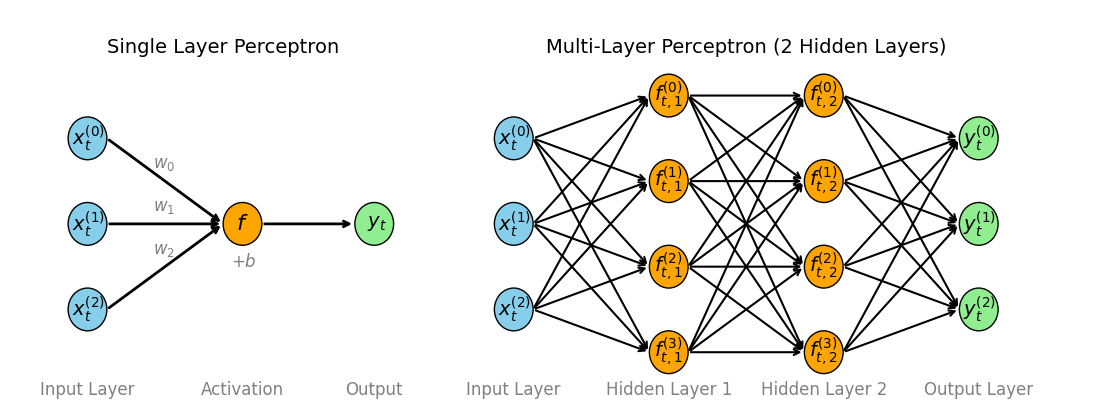

In [10]:
import matplotlib.pyplot as plt

def draw_perceptron_and_mlp_two_hidden():
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.axis('off')

    # --- Single Layer Perceptron (Left Side) ---
    input_coords = [(1, 2.5), (1, 1.5), (1, 0.5)]
    for index, (x, y) in enumerate(input_coords):
        ax.add_patch(plt.Circle((x, y), 0.25, color='skyblue', ec='black'))
        ax.text(x - 0.2, y, f"$x^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(input_coords[0][0], -0.5, "Input Layer", fontsize=12, ha='center', color='gray')

    perceptron_x, perceptron_y = 3, 1.5
    ax.add_patch(plt.Circle((perceptron_x, perceptron_y), 0.25, color='orange', ec='black'))
    ax.text(perceptron_x, perceptron_y, '$f$', fontsize=16, ha='center', va='center', color='black')
    ax.text(perceptron_x, -0.5, "Activation", fontsize=12, ha='center', color='gray')

    output_x, output_y = 4.7, 1.5
    ax.add_patch(plt.Circle((output_x, output_y), 0.25, color='lightgreen', ec='black'))
    ax.text(output_x -0.1, output_y, '$y_t$', fontsize=14, va='center')
    ax.text(output_x, -0.5, "Output", fontsize=12, ha='center', color='gray')

    for x, y in input_coords:
        ax.annotate('', xy=(perceptron_x - 0.25, perceptron_y), xytext=(x + 0.25, y),
                    arrowprops=dict(arrowstyle='->', lw=2))

    ax.annotate('', xy=(output_x - 0.25, output_y), xytext=(perceptron_x + 0.25, perceptron_y),
                arrowprops=dict(arrowstyle='->', lw=2))

    for i, (x, y) in enumerate(input_coords):
        ax.text((x + perceptron_x)/2 - 0.15, (y + perceptron_y)/2 + 0.15, f'$w_{i}$', fontsize=12, color='gray')
    ax.text(perceptron_x - 0.15, perceptron_y - 0.5, '$+b$', fontsize=12, color='gray')
    ax.text(2.75, 3.5, "Single Layer Perceptron", fontsize=14, ha='center')

    # --- Multi-Layer Perceptron (Right Side, with 2 hidden layers) ---
    x_offset = 6.5
    input_layer = [(x_offset + 0, 2.5), (x_offset + 0, 1.5), (x_offset + 0, 0.5)]
    hidden_layer1 = [(x_offset + 2, 3), (x_offset + 2, 2), (x_offset + 2, 1), (x_offset + 2, 0)]
    hidden_layer2 = [(x_offset + 4, 3), (x_offset + 4, 2), (x_offset + 4, 1), (x_offset + 4, 0)]
    output_layer = [(x_offset + 6, 2.5),(x_offset + 6, 1.5), (x_offset + 6, 0.5)]

    for index, (x, y) in enumerate(input_layer):
        ax.add_patch(plt.Circle((x, y), 0.25, color='skyblue', ec='black'))
        ax.text(x - 0.2, y, f"$x^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(input_layer[0][0], -0.5, "Input Layer", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(hidden_layer1):
        ax.add_patch(plt.Circle((x, y), 0.25, color='orange', ec='black'))
        ax.text(x, y, f"$f^{{({index})}}_{{t,1}}$", fontsize=14, ha='center', va='center', color='black')
    # Label for hidden layer 1
    ax.text(x_offset + 2, -0.5, "Hidden Layer 1", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(hidden_layer2):
        ax.add_patch(plt.Circle((x, y), 0.25, color='orange', ec='black'))
        ax.text(x, y, f"$f^{{({index})}}_{{t,2}}$", fontsize=14, ha='center', va='center', color='black')
    # Label for hidden layer 2
    ax.text(x_offset + 4, -0.5, "Hidden Layer 2", fontsize=12, ha='center', color='gray')

    for index, (x, y) in enumerate(output_layer):
        ax.add_patch(plt.Circle((x, y), 0.25, color='lightgreen', ec='black'))
        ax.text(x - 0.2, y, f"$y^{{({index})}}_t$", fontsize=14, va='center')
    ax.text(output_layer[0][0], -0.5, "Output Layer", fontsize=12, ha='center', color='gray')

    for xi, yi in input_layer:
        for xh, yh in hidden_layer1:
            ax.annotate('', xy=(xh - 0.25, yh), xytext=(xi + 0.25, yi),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    for xh1, yh1 in hidden_layer1:
        for xh2, yh2 in hidden_layer2:
            ax.annotate('', xy=(xh2 - 0.25, yh2), xytext=(xh1 + 0.25, yh1),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    for xh2, yh2 in hidden_layer2:
        for xh, yh in output_layer:
            ax.annotate('', xy=(xh - 0.25, yh), xytext=(xh2 + 0.25, yh2),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.text(x_offset + 3, 3.5, "Multi-Layer Perceptron (2 Hidden Layers)", fontsize=14, ha='center')

    ax.set_xlim(0, 14)
    ax.set_ylim(-0.5, 4)
    plt.show()

draw_perceptron_and_mlp_two_hidden()


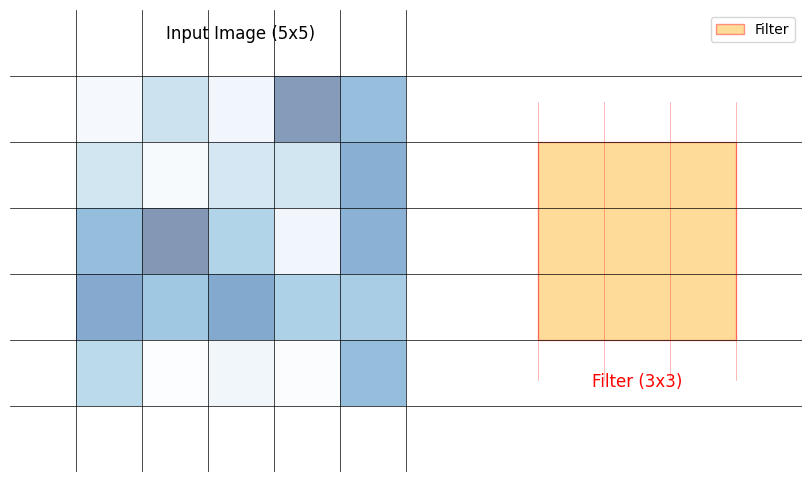

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define image and filter sizes
image_size = 5  # 5x5 image
filter_size = 3  # 3x3 filter

# Create the input image grid
image = np.random.rand(image_size, image_size)  # Random image for visualization
ax.imshow(image, cmap='Blues', extent=[0, image_size, 0, image_size], alpha=0.5)

# Draw grid lines for the image
for i in range(image_size + 1):
    ax.axhline(i, color='black', linewidth=0.5)
    ax.axvline(i, color='black', linewidth=0.5)

# Add the filter patch next to the image
filter_x = image_size + 2  # Offset to place filter to the right
filter_patch = patches.Rectangle((filter_x, 1), filter_size, filter_size, 
                                edgecolor='red', facecolor='orange', alpha=0.4, label='Filter')
ax.add_patch(filter_patch)

# Draw grid lines for the filter
for i in range(filter_size + 1):
    # Horizontal lines
    ax.axhline(1 + i, xmin=filter_x/image_size, xmax=(filter_x + filter_size)/image_size, 
               color='red', linewidth=0.5, alpha=0.4)
    # Vertical lines
    ax.axvline(filter_x + i, ymin=1/image_size, ymax=(1 + filter_size)/image_size, 
               color='red', linewidth=0.5, alpha=0.4)

# Add labels
ax.text(image_size/2, image_size + 0.5, 'Input Image (5x5)', ha='center', va='bottom', fontsize=12)
ax.text(filter_x + filter_size/2, 0.5, 'Filter (3x3)', ha='center', va='top', fontsize=12, color='red')

# Set plot limits
ax.set_xlim(-1, image_size + filter_size + 3)
ax.set_ylim(-1, image_size + 1)
ax.set_aspect('equal')
ax.axis('off')

# Add legend
ax.legend(loc='upper right')

plt.show()

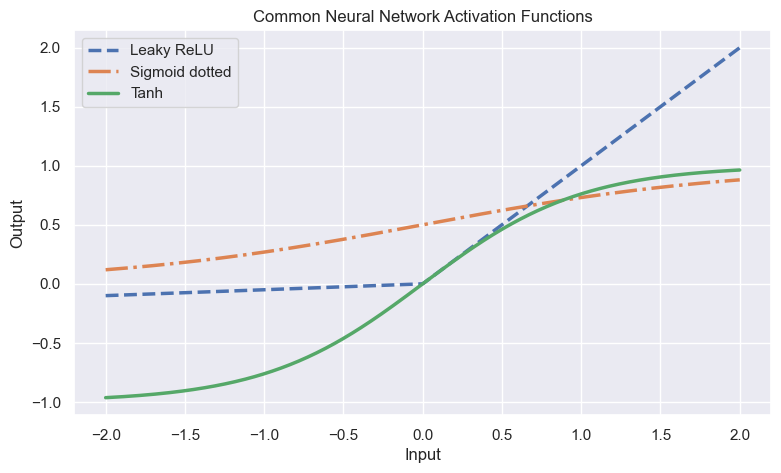

In [359]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
x = np.linspace(-2, 2, 500)
alpha = 0.05
leaky_relu = np.where(x > 0, x, alpha * x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

plt.figure(figsize=(9, 5))
plt.plot(x, leaky_relu, label='Leaky ReLU', linewidth=2.5, linestyle='--')
plt.plot(x, sigmoid, label='Sigmoid dotted', linewidth=2.5, linestyle='-.')
plt.plot(x, tanh, label='Tanh', linewidth=2.5)
plt.title('Common Neural Network Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.core.constants import NUMPY_X_KEY

file1 = r'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderfixedvol\scaled\AAPL_orderfixedvol_2025-06-04.npz'
file2 = r'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\ordervol\scaled\AAPL_ordervol_2025-06-04.npz'

with np.load(file1) as data1:
    data1 = data1[NUMPY_X_KEY]
    
with np.load(file2) as data2:
    data2 = data2[NUMPY_X_KEY]


<>:23: SyntaxWarning: invalid escape sequence '\k'
<>:23: SyntaxWarning: invalid escape sequence '\k'
C:\Users\benhu\AppData\Local\Temp\ipykernel_16800\131232882.py:23: SyntaxWarning: invalid escape sequence '\k'
  axs[0].set_xlabel("Fixed tick price $\kappa$")


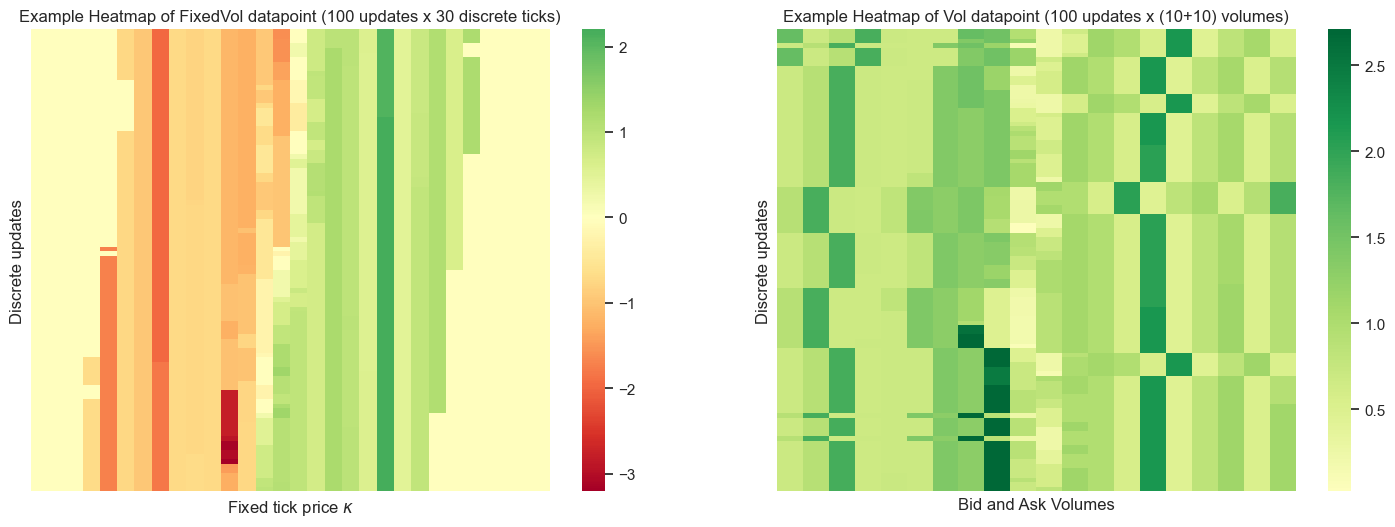

In [80]:
# index = 2000
index = 4500


example2 = data1[index]
pos2 = example2[example2 != 0]
ABS2 = np.abs(pos2)
MEAN2 = np.mean(ABS2)
normalised1 = example2 / MEAN2


example2 = data2[index]
pos2 = example2[example2 != 0]
ABS2 = np.abs(pos2)
MEAN2 = np.mean(ABS2)
normalised2 = example2 / MEAN2

# normalised for file1 is already present as 'normalised'

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(normalised1, cmap="RdYlGn", center=0, ax=axs[0], cbar=True)
axs[0].set_title('Example Heatmap of FixedVol datapoint (100 updates x 30 discrete ticks)')
axs[0].set_xlabel("Fixed tick price $\kappa$")
sns.heatmap(normalised2, cmap="RdYlGn", center=0, ax=axs[1], cbar=True)
axs[1].set_title('Example Heatmap of Vol datapoint (100 updates x (10+10) volumes)')
axs[1].set_xlabel("Bid and Ask Volumes")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("Discrete updates")
    
    # ax.set_xlabel(ax.get_xlabel())
    plt.subplots_adjust(wspace=0.15)
plt.show()

In [36]:
file = r'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderfixedvol\scaled\AAPL_orderfixedvol_2025-06-04.npz'
with np.load(file) as data:
    # print(list(data.keys()))
    data = data[NUMPY_X_KEY]
    print(data.shape)
np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True)
print(data[0])

(1901, 100, 30)
[[ 0.          0.          0.          0.          0.         -0.46802763 -1.58834574 -0.58595585 -1.10189183 -0.18426285 -1.20507902 -1.10557708 -1.05029823 -0.68177253 -1.62151306  0.
   0.19900388  1.38197135  1.75049705  0.55278854  1.44093547  1.12031811  0.96185206  0.8476091   0.7186251   5.45049502  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.46802763 -1.58834574 -0.58595585 -1.10189183 -0.18426285 -1.20507902 -1.10557708 -1.05029823 -0.68177253 -1.62151306  0.
   0.19900388  1.01344566  1.75049705  0.55278854  1.44093547  1.12031811  0.96185206  0.8476091   0.7186251   5.45049502  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.46802763 -1.58834574 -0.58595585 -1.10189183 -0.18426285 -1.20507902 -1.10557708 -1.05029823 -0.68177253 -1.54780792  0.
   0.19900388  1.01344566  1.75049705  0.55278854  1.44093547  1.12031811  0.9618520

In [7]:
import os
import json
import shutil
from datetime import datetime

project_root = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))

results_dir = os.path.join(project_root, 'results')

for filename in os.listdir(results_dir):
    if filename.endswith('.json'):
        file_path = os.path.join(results_dir, filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        # Extract date from 'datetime' field
        dt_str = data.get('datetime')
        if dt_str:
            # Try to parse the date (assume ISO format)
            try:
                dt = datetime.fromisoformat(dt_str)
            except ValueError:
            # If not ISO, try common formats
                dt = datetime.strptime(dt_str[:10], '%Y-%m-%d')
        else:
            # Use file creation time if no date string
            stat = os.stat(file_path)
            dt = datetime.fromtimestamp(stat.st_ctime)
        date_folder = dt.strftime('%Y-%m-%d')
        target_dir = os.path.join(results_dir, date_folder)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(file_path, os.path.join(target_dir, filename))

[]

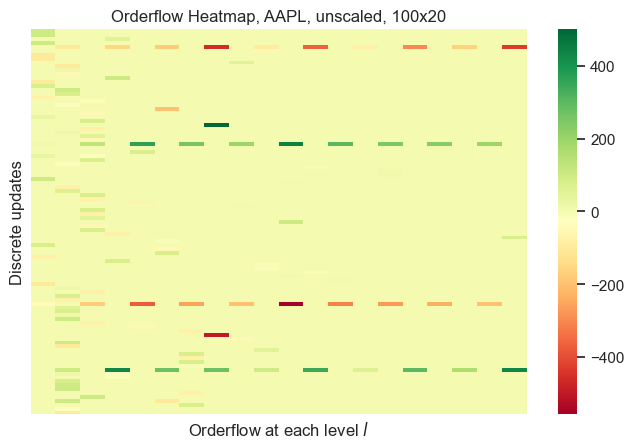

In [86]:
import pandas as pd
import seaborn as sns
of = r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderflows\unscaled\AAPL_orderflows_2025-06-04.csv"
df = pd.read_csv(of)
data = df.iloc[0:99,1:-2].values
plt.figure(figsize=(8, 5))
sns.heatmap(data=data, cmap="RdYlGn")
plt.title("Orderflow Heatmap, AAPL, unscaled, 100x20")
# plt.xticks(list(range(10, 0, -1)) + list(range(1, 11)))
plt.xticks([])
plt.yticks([])
plt.ylabel("Discrete updates")
plt.xlabel("Orderflow at each level $l$")
plt.plot()

[]

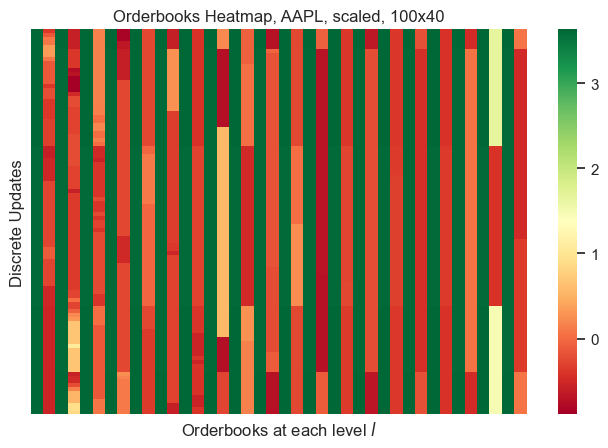

In [87]:
import pandas as pd
import seaborn as sns
of = r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderbooks\scaled\AAPL_orderbooks_2025-06-04.csv"
df = pd.read_csv(of)
plt.figure(figsize=(8, 5))
data = df.iloc[0:99,1:-2].values
sns.heatmap(data=data, cmap="RdYlGn")
plt.title("Orderbooks Heatmap, AAPL, scaled, 100x40")
# plt.xticks(list(range(10, 0, -1)) + list(range(1, 11)))
plt.xticks([])
plt.yticks([])
plt.ylabel("Discrete Updates")
plt.xlabel("Orderbooks at each level $l$")
plt.plot()

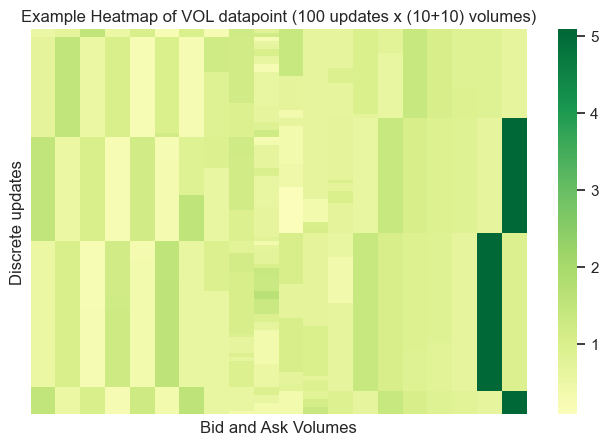

In [382]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.core.constants import NUMPY_X_KEY

file2 = r'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\ordervol\scaled\AAPL_ordervol_2025-06-04.npz'


with np.load(file2) as data2:
    data2 = data2[NUMPY_X_KEY]
    
    
    index = 100

    example2 = data2[index]
    pos2 = example2[example2 != 0]
    ABS2 = np.abs(pos2)
    MEAN2 = np.mean(ABS2)
    normalised2 = example2 / MEAN2

    plt.figure(figsize=(8, 5))
    sns.heatmap(normalised2, cmap="RdYlGn", center=0, cbar=True)
    plt.title('Example Heatmap of VOL datapoint (100 updates x (10+10) volumes)')
    plt.xlabel("Bid and Ask Volumes")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Discrete updates")
    plt.show()

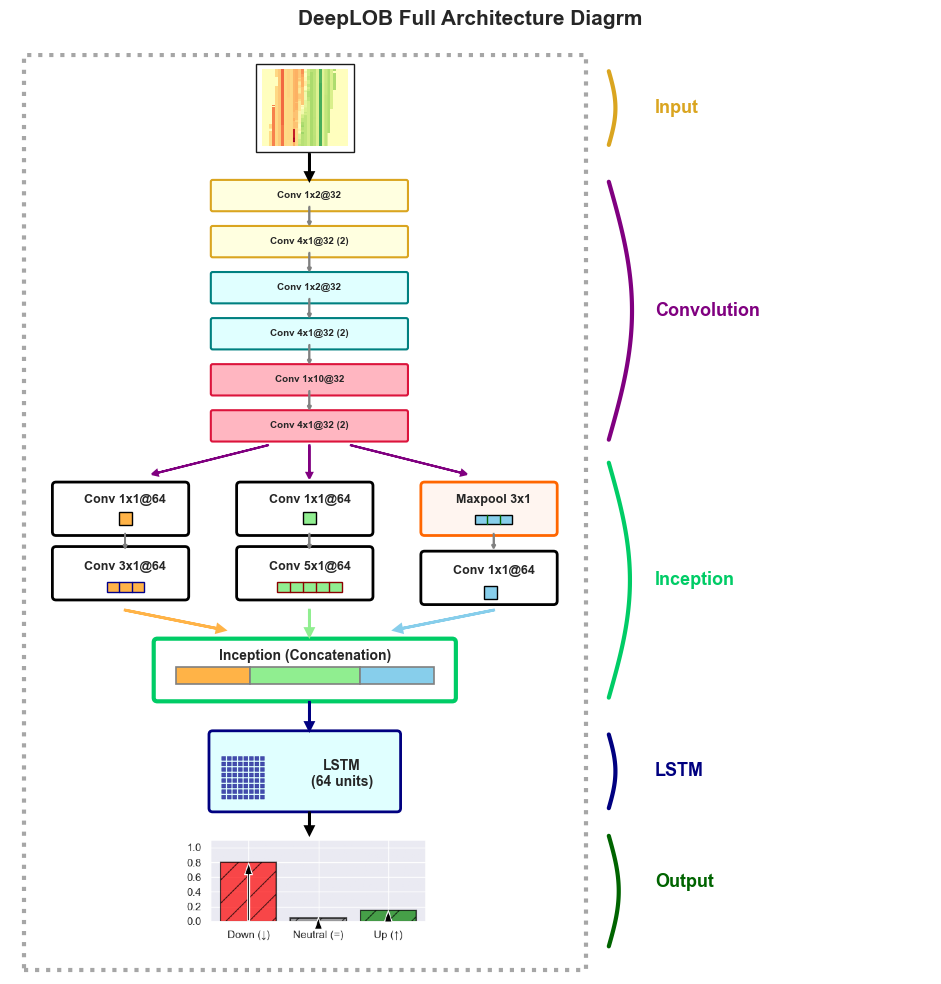

In [369]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')

# Define colors
box_color = 'white'
box_edge = 'black'
maxpool_color = '#fff5f0'
maxpool_edge = '#ff6600'
concat_color = 'white'
concat_edge = '#00cc66'
arrow_color = '#4CAF50'
line_color = '#666666'

# Add input processing stack with more space and smaller size, moved down by 1.5
offset_y = 1.2

input_box1 = FancyBboxPatch((2.2, 9.5 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightyellow', edgecolor='goldenrod', linewidth=1.5)
ax.add_patch(input_box1)
ax.text(3.25, 9.65 - offset_y, 'Conv 1x2@32', fontsize=7, fontweight='bold', ha='center', va='center')

input_box2 = FancyBboxPatch((2.2, 9 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightyellow', edgecolor='goldenrod', linewidth=1.5)
ax.add_patch(input_box2)
ax.text(3.25, 9.15 - offset_y, 'Conv 4x1@32 (2)', fontsize=7, fontweight='bold', ha='center', va='center')

input_box3 = FancyBboxPatch((2.2, 8.5 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightcyan', edgecolor='teal', linewidth=1.5)
ax.add_patch(input_box3)
ax.text(3.25, 8.65 - offset_y, 'Conv 1x2@32', fontsize=7, fontweight='bold', ha='center', va='center')

input_box4 = FancyBboxPatch((2.2, 8 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightcyan', edgecolor='teal', linewidth=1.5)
ax.add_patch(input_box4)
ax.text(3.25, 8.15 - offset_y, 'Conv 4x1@32 (2)', fontsize=7, fontweight='bold', ha='center', va='center')

input_box5 = FancyBboxPatch((2.2, 7.5 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightpink', edgecolor='crimson', linewidth=1.5)
ax.add_patch(input_box5)
ax.text(3.25, 7.65 - offset_y, 'Conv 1x10@32', fontsize=7, fontweight='bold', ha='center', va='center')

input_box6 = FancyBboxPatch((2.2, 7 - offset_y), 2.1, 0.3, boxstyle="round,pad=0.02", 
                           facecolor='lightpink', edgecolor='crimson', linewidth=1.5)
ax.add_patch(input_box6)
ax.text(3.25, 7.15 - offset_y, 'Conv 4x1@32 (2)', fontsize=7, fontweight='bold', ha='center', va='center')

# Add arrows from final input layer to the three parallel paths, shifted down by 0.6
arrow_down_shift = 0.6

# To first conv
ax.arrow(2.8, 6.34 - arrow_down_shift, -1.2, -0.3, head_width=0.06, head_length=0.06, 
         fc='purple', ec='purple', linewidth=1.5)

# To second conv  
ax.arrow(3.25, 6.34 - arrow_down_shift, 0, -0.3, head_width=0.06, head_length=0.06, 
         fc='purple', ec='purple', linewidth=1.5)

# To third conv
ax.arrow(3.7, 6.34 - arrow_down_shift, 1.2, -0.3, head_width=0.06, head_length=0.06, 
         fc='purple', ec='purple', linewidth=1.5)

# Add connecting arrows between the stack layers
for i in range(5):
    y_start = 9.35 - (i+1) * 0.5
    y_end = y_start - 0.25
    ax.arrow(3.25, y_start -0.52, 0, -0.16, head_width=0.04, head_length=0.04, 
             fc='gray', ec='gray', linewidth=1.2)

# Load and add the image below the convolution stack
try:
    img = plt.imread(r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\assets\deepvol_pure_image.png")
    imagebox = OffsetImage(img, zoom=0.12)
    ab = AnnotationBbox(imagebox, (3.2, 9.4), frameon=True)
    ax.add_artist(ab)
except FileNotFoundError:
    ax.text(3, 8.5, 'DeepVol Image\n(Image not found)', fontsize=9, 
            ha='center', va='center', bbox=dict(boxstyle="round,pad=0.2", 
            facecolor='lightblue', edgecolor='blue'))
    
ax.arrow(3.25, 8.9, 0, -.2, head_width=0.08, head_length=0.08, fc='black', ec='black', linewidth=2)

    
    
# Draw each section with different colors
colors = ['#FFB347', '#90EE90', '#87CEEB']  # orange, light green, light blue

# Top row boxes
# Conv 1x1@32 (top left, black border, no fill)
box1 = FancyBboxPatch((0.5, 4.8), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor='none', edgecolor='black', linewidth=2)
ax.add_patch(box1)
ax.text(1.25, 5.15, 'Conv 1x1@64', fontsize=9, fontweight='bold', ha='center', va='center')
# 1x1 filter: small square
filter1 = patches.Rectangle((1.18, 4.87), 0.14, 0.14, facecolor=colors[0], edgecolor='black', linewidth=1)
ax.add_patch(filter1)

# Conv 1x1@32 (top middle, black border, no fill)
box2 = FancyBboxPatch((2.5, 4.8), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor='none', edgecolor='black', linewidth=2)
ax.add_patch(box2)
ax.text(3.25, 5.15, 'Conv 1x1@64', fontsize=9, fontweight='bold', ha='center', va='center')
# 1x1 filter: small square
filter2 = patches.Rectangle((3.18, 4.88), 0.14, 0.14, facecolor=colors[1], edgecolor='black', linewidth=1)
ax.add_patch(filter2)

# Maxpool 3x1
box3 = FancyBboxPatch((4.5, 4.8), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor=maxpool_color, edgecolor=maxpool_edge, linewidth=2)
ax.add_patch(box3)
# Center the text in the middle of the maxpool box
ax.text(5.25, 5.15, 'Maxpool 3x1', fontsize=9, fontweight='bold', ha='center', va='center')
filter3 = patches.Rectangle((5.05, 4.88), 0.4, 0.1, facecolor=colors[2], edgecolor='black', linewidth=1)
ax.add_patch(filter3)
# Add vertical lines on the rectangle
ax.plot([5.18, 5.18], [4.88, 4.98], color='darkgreen', linewidth=1)
ax.plot([5.32, 5.32], [4.88, 4.98], color='darkgreen', linewidth=1)

# Bottom row boxes
# Conv 3x1@32
# Conv 3x1@32
box4 = FancyBboxPatch((0.5, 4.10), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor=box_color, edgecolor=box_edge, linewidth=2)
ax.add_patch(box4)
ax.text(1.25, 4.42, 'Conv 3x1@64', fontsize=9, fontweight='bold', ha='center', va='center')
filter4 = patches.Rectangle((1.05, 4.15), 0.4, 0.1, facecolor=colors[0], edgecolor='darkblue', linewidth=1)
ax.add_patch(filter4)
ax.plot([1.18, 1.18], [4.15, 4.25], color='darkblue', linewidth=1)
ax.plot([1.32, 1.32], [4.15, 4.25], color='darkblue', linewidth=1)

# Conv 5x1@32
box5 = FancyBboxPatch((2.5, 4.10), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor=box_color, edgecolor=box_edge, linewidth=2)
ax.add_patch(box5)
ax.text(3.25, 4.42, 'Conv 5x1@64', fontsize=9, fontweight='bold', ha='center', va='center')
filter5 = patches.Rectangle((2.9, 4.15), 0.7, 0.1, facecolor=colors[1], edgecolor='darkred', linewidth=1)
ax.add_patch(filter5)
ax.plot([3.04, 3.04], [4.15, 4.25], color='darkred', linewidth=1)
ax.plot([3.18, 3.18], [4.15, 4.25], color='darkred', linewidth=1)
ax.plot([3.32, 3.32], [4.15, 4.25], color='darkred', linewidth=1)
ax.plot([3.46, 3.46], [4.15, 4.25], color='darkred', linewidth=1)

# Conv 1x1@32
box6 = FancyBboxPatch((4.5, 4.05), 1.4, 0.5, boxstyle="round,pad=0.04", 
                      facecolor=box_color, edgecolor=box_edge, linewidth=2)
ax.add_patch(box6)
ax.text(5.25, 4.37, 'Conv 1x1@64', fontsize=9, fontweight='bold', ha='center', va='center')
filter6 = patches.Rectangle((5.15, 4.07), 0.14, 0.14, facecolor=colors[2], edgecolor='black', linewidth=1)
ax.add_patch(filter6)

# Concat box with more space, moved up and centered
concat_box = FancyBboxPatch((1.6, 3), 3.2, 0.6, boxstyle="round,pad=0.04", 
                           facecolor=concat_color, edgecolor=concat_edge, linewidth=3)
ax.add_patch(concat_box)
ax.text(3.2, 3.45, 'Inception (Concatenation)', fontsize=10, fontweight='bold', ha='center', va='center')

# Add horizontal rectangle inside concat box, made of three sections
rect_y = 3.15  # vertical position inside concat box
rect_height = 0.18
rect_x_start = 1.8
rect_widths = [0.8, 1.2, 0.8]  # widths for each section

# Draw each section with different colors
colors = ['#FFB347', '#90EE90', '#87CEEB']  # orange, light green, light blue

x_pos = rect_x_start
for w, c in zip(rect_widths, colors):
    ax.add_patch(patches.Rectangle((x_pos, rect_y), w, rect_height, facecolor=c, edgecolor='gray', linewidth=1.2))
    x_pos += w

# Add arrows from top row to bottom row, shifted upwards by 0.3
arrow_shift = -1.02
ax.arrow(1.25, 5.8 + arrow_shift, 0, -0.12, head_width=0.04, head_length=0.04, 
             fc='gray', ec='gray', linewidth=1.2)
ax.arrow(3.25, 5.8 + arrow_shift, 0, -0.12, head_width=0.04, head_length=0.04, 
             fc='gray', ec='gray', linewidth=1.25)
ax.arrow(5.25, 5.8 + arrow_shift, 0, -0.12, head_width=0.04, head_length=0.04, 
             fc='gray', ec='gray', linewidth=1.2)

# Add diagonal arrws from bottom boxes to concat, starting slightly higher
ax.arrow(1.25, 3.95, 1, -.2, head_width=0.08, head_length=0.08, 
         fc=colors[0], ec=colors[0], linewidth=2)
ax.arrow(3.25, 3.95, 0, -0.2, head_width=0.08, head_length=0.08, 
         fc=colors[1], ec=colors[1], linewidth=2)
ax.arrow(5.25, 3.95, -1, -0.2, head_width=0.08, head_length=0.08, 
         fc=colors[2], ec=colors[2], linewidth=2)

# Variable to control vertical shift of LSTM box and related elements
vertical_shift = 1.3  # Change this value to move LSTM and arrow up/down

# Add LSTM box with more space, moved up by vertical_shift
lstm_box = FancyBboxPatch((2.2, 0.5 + vertical_shift), 2, 0.8, boxstyle="round,pad=0.04", 
                         facecolor='lightcyan', edgecolor='navy', linewidth=2)
ax.add_patch(lstm_box)

# Add miniature boxes inside LSTM to represent 64 LSTM units, shifted up
box_size = 0.04
start_x = 2.3
start_y = 0.6 + vertical_shift
spacing = 0.06

for i in range(8):
    for j in range(8):
        x = start_x + j * spacing
        y = start_y + i * spacing
        mini_lstm = FancyBboxPatch((x, y), box_size, box_size, 
                                  boxstyle="round,pad=0.001", 
                                  facecolor='darkblue', edgecolor='navy', 
                                  linewidth=0.3, alpha=0.7)
        ax.add_patch(mini_lstm)

ax.text(3.6, 0.87 + vertical_shift, 'LSTM\n(64 units)', fontsize=10, fontweight='bold', ha='center', va='center')

# Add arrow from concat to LSTM, shifted up
ax.arrow(3.25, 1.65 + vertical_shift, 0, -.22, head_width=0.08, head_length=0.08, fc='navy', ec='navy', linewidth=2)
# Add vertical offset for Output box
output_vertical_offset = 1.0

# Add Output box with more space, made taller, moved up by output_vertical_offset
# output_box = FancyBboxPatch((2.0, -0.7 + output_vertical_offset), 2.4, 1.2, boxstyle="round,pad=0.04", 
#                             facecolor="#D8D8D8", edgecolor='black', linewidth=2)
# ax.add_patch(output_box)
# ax.text(3.25, 0.35 + output_vertical_offset, 'Dense', fontsize=10, fontweight='bold', ha='center', va='center')

ax.arrow(3.25, 0.45 + vertical_shift, 0, -.15, head_width=0.08, head_length=0.08, fc='black', ec='black', linewidth=2)

# Add image inside Output box (categorical output example)
try:
    img_out = plt.imread(r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\assets\example_categorical_output_2.png")
    imagebox_out = OffsetImage(img_out, zoom=0.5)
    ab_out = AnnotationBbox(imagebox_out, (3.2, -0.1 + output_vertical_offset), frameon=False)
    ax.add_artist(ab_out)
except FileNotFoundError:
    ax.text(3.2, -0.1 + output_vertical_offset, 'Output Image\n(Image not found)', fontsize=8, 
            ha='center', va='center', bbox=dict(boxstyle="round,pad=0.2", 
            facecolor='lightgray', edgecolor='gray'))


# Extend dotted border to include LSTM and Output
# Increase height and lower y to ensure the bottom is not cut off
dotted_border = patches.Rectangle((0.15, 0.04), 6.1, 9.94, linewidth=3, 
                                 edgecolor='gray', facecolor='none', 
                                 linestyle='dotted', alpha=0.7)
ax.add_patch(dotted_border)


# Add curly braces and annotations for each section

def draw_curly_brace(ax, x, y1, y2, width=0.3, direction='right', color='black', lw=2):
    """Draw a vertical curly brace between y1 and y2 at x."""
    # Number of points for the curve
    n = 100
    y = np.linspace(y1, y2, n)
    h = y2 - y1
    # Parametric curly brace
    t = np.linspace(0, 1, n)
    brace = (np.sin(np.pi * t) * width * h / 2)
    if direction == 'right':
        x_curve = x + brace
    else:
        x_curve = x - brace
    ax.plot(x_curve, y, color=color, lw=lw)

# Input section
x_axis_curley = 6.5
x_axis_text = 7

draw_curly_brace(ax, x_axis_curley, 9, 9.8, width=0.18, color='goldenrod', lw=3)
ax.text(x_axis_text, 9.4, 'Input', fontsize=13, fontweight='bold', va='center', ha='left', color='goldenrod')

# Convolution section
draw_curly_brace(ax, x_axis_curley, 5.8, 8.6, width=0.18, color='purple', lw=3)
ax.text(x_axis_text, 7.2, 'Convolution', fontsize=13, fontweight='bold', va='center', ha='left', color='purple')

# Inception section
draw_curly_brace(ax, x_axis_curley, 3.0, 5.55, width=0.18, color='#00cc66', lw=3)
ax.text(x_axis_text, 4.28, 'Inception', fontsize=13, fontweight='bold', va='center', ha='left', color='#00cc66')

# LSTM section
draw_curly_brace(ax, x_axis_curley, 0.5 + vertical_shift, 1.3 + vertical_shift, width=0.18, color='navy', lw=3)
ax.text(x_axis_text, 0.9 + vertical_shift, 'LSTM', fontsize=13, fontweight='bold', va='center', ha='left', color='navy')

# Output section
draw_curly_brace(ax, x_axis_curley, -0.7 + output_vertical_offset, 0.5 + output_vertical_offset, width=0.18, color='darkgreen', lw=3)
ax.text(x_axis_text, 0.0 + output_vertical_offset, 'Output', fontsize=13, fontweight='bold', va='center', ha='left', color='darkgreen')

plt.title('DeepLOB Full Architecture Diagrm', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

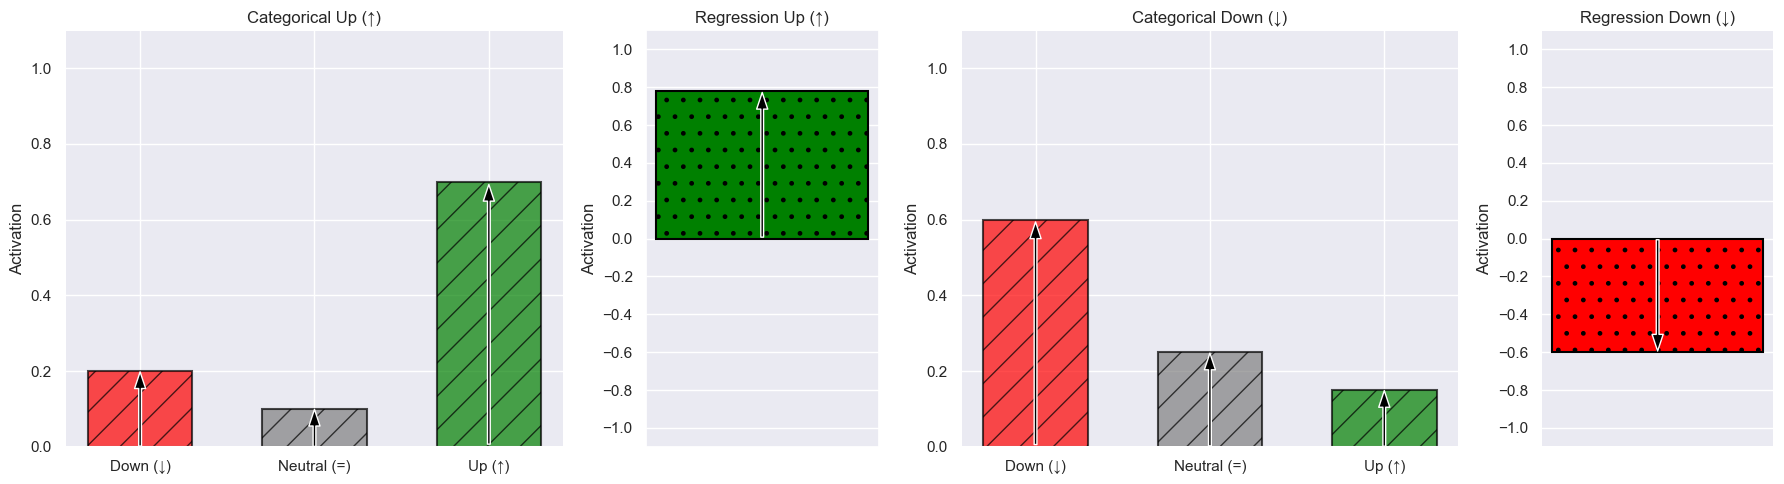

In [377]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Example regression predictions for each category
regression_values = [0.78, -0.6]

# Make the two regression axes thinner by adjusting their position and width

plt.clf()
fig = plt.figure(figsize=(18, 5))
gs = GridSpec(1, 4, width_ratios=[1.5, 0.7, 1.5, 0.7])
axs = [fig.add_subplot(gs[i]) for i in range(4)]

sns.set()
categories = ['Down (↓)', 'Neutral (=)', 'Up (↑)']
colors = ['red', 'grey', 'green']

# Categorical (wide)
softmax_probs = [0.2, 0.1, 0.7]
softmax_probs2 = [0.6, 0.25, 0.15]
axs[0].bar(categories, softmax_probs, color=colors, width=0.6,  edgecolor='black', linewidth=1.5, alpha=0.7, hatch='/')
axs[0].set_ylim(0, 1.1)
axs[0].set_title('Categorical Up (↑)')
axs[0].set_ylabel('Activation')
axs[0].set_xticks(range(3))
axs[0].set_xticklabels(categories)
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
for spine in axs[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# Regression (thin)
axs[1].bar(categories[0], regression_values[0], color=colors[2], width=0.18, edgecolor='black', linewidth=1.5, hatch='.')
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_title(f'Regression Up (↑)')
axs[1].set_ylabel('Activation')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks(np.arange(-1, 1.01, 0.2))
axs[1].grid(True, axis='y')
for spine in axs[3].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
# Regression (thin)
axs[3].bar(categories[1], regression_values[1], color=colors[0], width=0.18, edgecolor='black', linewidth=1.5, hatch='.')
axs[3].set_ylim(-1.1, 1.1)
axs[3].set_title(f'Regression Down (↓)')
axs[3].set_ylabel('Activation')
axs[3].set_xticks([])
axs[3].set_xticklabels([])
axs[3].set_yticks(np.arange(-1, 1.01, 0.2))
axs[3].grid(True, axis='y')
for spine in axs[i+1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# Categorical (wide)
# Yes, there are different styles of bars in matplotlib.
# You can customize bar appearance using parameters like color, edgecolor, linewidth, alpha, hatch, orientation, etc.

# Example: using hatch pattern and transparency
axs[2].bar(categories, softmax_probs2, color=colors, width=0.6, edgecolor='black', linewidth=1.5, alpha=0.7, hatch='/')
axs[2].set_ylim(0, 1.1)
axs[2].set_title('Categorical Down (↓)')
axs[2].set_ylabel('Activation')
axs[2].set_xticks(range(3))
axs[2].set_xticklabels(categories)
axs[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
for spine in axs[2].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)


for idx, prob in enumerate(softmax_probs):
    axs[0].annotate('', xy=(idx, prob), xytext=(idx, 0),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=2, headwidth=8))
for idx, prob in enumerate(softmax_probs2):    
    axs[2].annotate('', xy=(idx, prob), xytext=(idx, 0),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=2, headwidth=8))
                    # Annotate regression bars with arrows (make sure the arrow is at the correct x position)
for i in range(2):
    axs[2*i+1].annotate(
        '', 
        xy=(0, regression_values[i]), xytext=(0, 0),
        arrowprops=dict(facecolor='black', shrink=0.01, width=2, headwidth=8)
    )

plt.tight_layout()
plt.show()





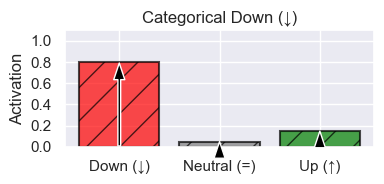

In [365]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

sns.set()
categories = ['Down (↓)', 'Neutral (=)', 'Up (↑)']
colors = ['red', 'grey', 'green']
softmax_probs2 = [0.8, 0.05, 0.15]

plt.figure(figsize=(4, 2))
plt.bar(categories, softmax_probs2, color=colors, width=0.8, edgecolor='black', linewidth=1.5, alpha=0.7, hatch='/')
plt.ylim(0, 1.1)
plt.title('Categorical Down (↓)')
plt.ylabel('Activation')
plt.xticks(range(3), categories)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
for idx, prob in enumerate(softmax_probs2):    
    plt.annotate('', xy=(idx, prob), xytext=(idx, 0),
                 arrowprops=dict(facecolor='black', shrink=0.01, width=2, headwidth=8))
plt.tight_layout()
plt.show()